In [1]:
from fastmcp import Client

from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, MatchValue

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

import psycopg2
import numpy as np
from psycopg2.extras import RealDictCursor

### Helper Functions needed to run the following code

In [2]:
def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [3]:
async def get_tool_descriptions_from_mcp_servers(mcp_servers: list[str]) -> list[dict]:

    tool_descriptions = []

    for server in mcp_servers:

        client = Client(server)

        async with client:

            tools = await client.list_tools()

            for tool in tools:
                
                result = {
                    "name": "",
                    "description": "",
                    "parameters": {"type": "object", "properties": {}},
                    "required": [],
                    "returns": {"type": "string", "description": ""},
                    "server": server
                }

                result["name"] = tool.name
                result["required"] = tool.inputSchema.get("required", [])

                ## Get Description

                description = tool.description.split("\n\n")[0]
                result["description"] = description


                ## Get Returns

                returns = tool.description.split("Returns:")[1].strip()
                result["returns"]["description"] = returns

                ## Get parameters

                property_descriptions = parse_docstring_params(tool.description)
                properties = tool.inputSchema.get("properties", {})
                for key, value in properties.items():
                    properties[key]["description"] = property_descriptions.get(key, "")

                result["parameters"]["properties"] = properties

                tool_descriptions.append(result)

    return tool_descriptions

In [4]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

In [5]:
def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""}
    }
    
    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result
        
    func = tree.body[0]
    result["name"] = func.name
    
    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = docstring.find('\n\n') if '\n\n' in docstring else docstring.find('\nArgs:')
        desc_end = desc_end if desc_end > 0 else docstring.find('\nParameters:')
        result["description"] = docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        
        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)
        
        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = docstring.split("Returns:")[1].strip().split('\n')[0]
    
    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)
    
    for i, arg in enumerate(args.args):
        if arg.arg == 'self':
            continue
            
        param_info = {
            "type": get_type_from_annotation(arg.annotation) if arg.annotation else "string",
            "description": param_descs.get(arg.arg, "")
        }
        
        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)
        
        result["parameters"]["properties"][arg.arg] = param_info
    
    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)
    
    return result


def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"
    
    type_map = {
        'str': 'string',
        'int': 'integer', 
        'float': 'number',
        'bool': 'boolean',
        'list': 'array',
        'dict': 'object',
        'List': 'array',
        'Dict': 'object'
    }
    
    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(annotation.value, ast.Name):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())
    
    return "string"


def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params


def get_tool_descriptions_from_node(tool_node):
    """Extract tool descriptions from the ToolNode object."""
    descriptions = []
    
    if hasattr(tool_node, 'tools_by_name'):
        tools_by_name = tool_node.tools_by_name
        
        for tool_name, tool in tools_by_name.items():
            function_string = inspect.getsource(globals()[tool_name])
            # function_string = inspect.getsource(getattr(tool_name))
            result = parse_function_definition(function_string)

            if result:
                descriptions.append(result)
    
    return descriptions if descriptions else "Could not extract tool descriptions"


def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

### Pydantic Models

In [6]:
class MCPToolCall(BaseModel):
    name: str
    arguments: dict
    server: str

class RAGUsedContext(BaseModel):
    id: int
    description: str

class ProductQAAgentResponse(BaseModel):
    answer: str
    tool_calls: List[MCPToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

In [7]:
class Delegation(BaseModel):
    agent: str
    task: str = Field(default="")

class CoordinatorAgentResponse(BaseModel):
    next_agent: str
    plan: list[Delegation]
    final_answer: bool = Field(default=False)
    answer: str

In [8]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class ShoppingCartAgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)

In [9]:
class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    answer: str = ""
    product_qa_iteration: int = Field(default=0)
    shopping_cart_iteration: int = Field(default=0)
    coordinator_iteration: int = Field(default=0)
    product_qa_final_answer: bool = Field(default=False)
    shopping_cart_final_answer: bool = Field(default=False)
    coordinator_final_answer: bool = Field(default=False)
    product_qa_available_tools: List[Dict[str, Any]] = []
    shopping_cart_available_tools: List[Dict[str, Any]] = []
    mcp_tool_calls: Optional[List[MCPToolCall]] = Field(default_factory=list)
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context_ids: List[RAGUsedContext] = Field(default_factory=list)
    user_id: str = ""
    cart_id: str = ""
    plan: list[Delegation] = Field(default_factory=list)
    next_agent: str = ""

### The Product QA Agent Node

In [10]:
@traceable(
    name="product_qa_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def product_qa_agent_node(state: State) -> dict:

   prompt_template =  """You are an Agent, part of a shopping assistant that can answer questions about the products in stock.

You will be given a conversation history and a list of tools you can use to answer that question.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

After the tools are used you will get the outputs from the tools.

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specificly provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

CRITICAL RULES:
- If tool_calls has values, final_answer MUST be false
  (You cannot call tools and return to coordinator in the same response)
- If final_answer is true, tool_calls MUST be []
  (You must wait for tool results before returning to coordinator)
- If you need tool results before answering, set:
  tool_calls=[...], final_answer=false
- After receiving tool results, you can then set:
  tool_calls=[], final_answer=true

Instructions:
- You need to answer the question based on the retrieved context using the available tools only.
- Never use word context and refer to it as the available products.
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
- As a final output you need to provide:

* The answer to the question based on the retrieved context.
* The list of the indexes from the chunks returned from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
* Short description of the item based on the retrieved context.

- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.
- The short description should have the name of the item.
- If the user's request requires using a tool, set tool_calls with the appropriate function name and arguments.
- If you have all the information needed to provide a complete answer, set final_answer to True.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.product_qa_available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=ProductQAAgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.final_answer:
      ai_message = AIMessage(
         content=response.answer,
      )
   elif response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "mcp_tool_calls": response.tool_calls,
      "product_qa_iteration": state.product_qa_iteration + 1,
      "answer": response.answer,
      "product_qa_final_answer": response.final_answer,
      "retrieved_context_ids": response.retrieved_context_ids
   }

### The Shopping Cart Agent Node

#### Write to shopping cart tool

In [11]:
def add_to_shopping_cart(items: list[dict], user_id: str, cart_id: str) -> str:

    """Add a list of provided items to the shopping cart.
    
    Args:
        items: A list of items to add to the shopping cart. Each item is a dictionary with the following keys: product_id, quantity.
        user_id: The id of the user to add the items to the shopping cart.
        cart_id: The id of the shopping cart to add the items to.
        
    Returns:
        A list of the items added to the shopping cart.
    """

    conn = psycopg2.connect(
        host="localhost",
        port=5433,
        database="langgraph_db",
        user="langgraph_user",
        password="langgraph_password"
    )
    conn.autocommit = True

    with conn.cursor(cursor_factory=RealDictCursor) as cursor:
        
        for item in items:
            product_id = item['product_id']
            quantity = item['quantity']

            qdrant_client = QdrantClient(url="http://localhost:6333")

            dummy_vector = np.zeros(1536).tolist()
            payload = qdrant_client.query_points(
                collection_name="Amazon-items-collection-02-items",
                query=dummy_vector,
                query_filter=Filter(
                    must=[
                        FieldCondition(
                            key="parent_asin",
                            match=MatchValue(value=product_id)
                        )
                    ]
                ),
                with_payload=True,
                limit=1
            ).points[0].payload

            product_image_url = payload.get("first_large_image")
            price = payload.get("price")
            currency = 'USD'
        
            # Check if item already exists
            check_query = """
                SELECT id, quantity, price 
                FROM shopping_carts.shopping_cart_items 
                WHERE user_id = %s AND shopping_cart_id = %s AND product_id = %s
            """
            cursor.execute(check_query, (user_id, cart_id, product_id))
            existing_item = cursor.fetchone()
            
            if existing_item:
                # Update existing item
                new_quantity = existing_item['quantity'] + quantity
                
                update_query = """
                    UPDATE shopping_carts.shopping_cart_items 
                    SET 
                        quantity = %s,
                        price = %s,
                        currency = %s,
                        product_image_url = COALESCE(%s, product_image_url)
                    WHERE user_id = %s AND shopping_cart_id = %s AND product_id = %s
                    RETURNING id, quantity, price
                """
                
                cursor.execute(update_query, (new_quantity, price, currency, product_image_url, user_id, cart_id, product_id))
            
            else:
                # Insert new item
                insert_query = """
                    INSERT INTO shopping_carts.shopping_cart_items (
                        user_id, shopping_cart_id, product_id,
                        price, quantity, currency, product_image_url
                    ) VALUES (%s, %s, %s, %s, %s, %s, %s)
                    RETURNING id, quantity, price
                """
                
                cursor.execute(insert_query, (user_id, cart_id, product_id, price, quantity, currency, product_image_url))
            
    return f"Added {items} to the shopping cart."

#### Get the shopping cart tool

In [12]:
def get_shopping_cart(user_id: str, cart_id: str) -> list[dict]:

    """
    Retrieve all items in a user's shopping cart.
    
    Args:
        user_id: User ID
        shopping_cart_id: Cart identifier
    
    Returns:
        List of dictionaries containing cart items
    """
    
    conn = psycopg2.connect(
        host="localhost",
        port=5433,
        database="langgraph_db",
        user="langgraph_user",
        password="langgraph_password"
    )
    conn.autocommit = True

    with conn.cursor(cursor_factory=RealDictCursor) as cursor:

        query = """
                SELECT 
                    product_id, price, quantity,
                    currency, product_image_url,
                    (price * quantity) as total_price
                FROM shopping_carts.shopping_cart_items 
                WHERE user_id = %s AND shopping_cart_id = %s
                ORDER BY added_at DESC
            """
        cursor.execute(query, (user_id, cart_id))

        return [dict(row) for row in cursor.fetchall()]

#### Delete from shopping cart tool

In [13]:
def remove_from_cart(product_id: str, user_id: str, cart_id: str) -> str:

    """
    Remove an item completely from the shopping cart.
    
    Args:
        user_id: User ID
        product_id: Product ID to remove
        shopping_cart_id: Cart identifier
    
    Returns:
        True if item was removed, False if item wasn't found
    """
    
    conn = psycopg2.connect(
        host="localhost",
        port=5433,
        database="langgraph_db",
        user="langgraph_user",
        password="langgraph_password"
    )
    conn.autocommit = True

    with conn.cursor(cursor_factory=RealDictCursor) as cursor:

        query = """
                DELETE FROM shopping_carts.shopping_cart_items
                WHERE user_id = %s AND shopping_cart_id = %s AND product_id = %s
            """
        cursor.execute(query, (user_id, cart_id, product_id))

        return cursor.rowcount > 0

In [14]:
@traceable(
    name="shopping_cart_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def shopping_cart_agent_node(state) -> dict:

   prompt_template =  """You are a part of the shopping assistant that can manage the user's shopping cart.

You will be given a conversation history and a list of tools, your task is to perform the action requested by the latest user query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When making tool calls, use this exact format:
{
   "name": "tool_name",
   "arguments": {
         "parameter1": "value1",
         "parameter2": "value2",
   }
}

CRITICAL: All parameters must go inside the "arguments" object, not at the top level of the tool call.

Examples:
- Remove item from shopping cart:
{
   "name": "remove_from_shopping_cart",
   "arguments": {
         "product_id": "123",
         "user_id": "123",
         "cart_id": "456"
   }
}

- Add item to shopping cart:
{
   "name": "add_to_shopping_cart",
   "arguments": {
         "items": [
            {
               "product_id": "123",
               "quantity": 1
            },
            {
               "product_id": "456",
               "quantity": 2
            }
         ],
         "user_id": "123",
         "cart_id": "456"
   }
}

- Get shopping cart:
{
   "name": "get_shopping_cart",
   "arguments": {
         "user_id": "123",
         "cart_id": "456"
   }
}

After the tools are used you will get the outputs from the tools.

Additional information:
- User ID: {{ user_id }}
- Cart ID: {{ cart_id }}

CRITICAL RULES:
- If tool_calls has values, final_answer MUST be false
  (You cannot call tools and return to coordinator in the same response)
- If final_answer is true, tool_calls MUST be []
  (You must wait for tool results before returning to coordinator)
- If you need tool results before answering, set:
  tool_calls=[...], final_answer=false
- After receiving tool results, you can then set:
  tool_calls=[], final_answer=true

Instructions:
- Use names specificly provided in the available tools. Don't add any additional text to the names.
- You can run multipple tools at once.
- Once you get the tool results back, you might choose to performa additional tool calls.
- Once your work is done, set final_answer to True, you should not suggest using more tools then.
- As the final answer you should return an answer to the users query in a form of actions performed.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.shopping_cart_available_tools,
      user_id=state.user_id,
      cart_id=state.cart_id
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=ShoppingCartAgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.final_answer:
      ai_message = AIMessage(
         content=response.answer,
      )
   elif response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
         )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "shopping_cart_iteration": state.shopping_cart_iteration + 1,
      "answer": response.answer,
      "shopping_cart_final_answer": response.final_answer
   }

### Coordinator Agent node

In [15]:
@traceable(
    name="coordinator_agent",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1"}
)
def coordinator_agent_node(state) -> dict:

   prompt_template =  """You are a Coordinator Agent as part of a shopping assistant.

Your role is to create plans for solving user queries and delegate the tasks accordingly.
You will be given a conversation history, your task is to create a plan for solving the user's query.
After the plan is created, you should output the next agent to invoke and the task to be performed by that agent.
Once an agent finishes its task, you will be handed the control back, you should then review the conversation history and revise the plan.
If there is a sequence of tasks to be performed by a single agent, you should combine them into a single task.

The possible agents are:

- product_qa_agent: The user is asking a question about a product. This can be a question about available products, their specifications, user reviews etc.
- shopping_cart_agent: The user is asking to add or remove items from the shopping cart or questions about the current shopping cart.

CRITICAL RULES:
- If next_agent is "", final_answer MUST be false
  (You cannot delegate the task to an agent and return to the user in the same response)
- If final_answer is true, next_agent MUST be ""
  (You must wait for agent results before returning to user)
- If you need to call other agents before answering, set:
  next_agent="...", final_answer=false
- After receiving agent results, you can then set:
  next_agent="", final_answer=true

Additional instructions:

- Write the plan to the plan field.
- Write the next agent to invoke to the next_agent field.
- Once you have all the information needed to answer the user's query, you should set the final_answer field to True and output the answer to the user's query.
- Never set final_answer to true if the plan is not complete.
- You should output the next_agent field as well as the plan field.
"""

   template = Template(prompt_template)
   
   prompt = template.render()

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1",
        response_model=CoordinatorAgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0,
   )

   if response.final_answer:
      ai_message = [AIMessage(
         content=response.answer,
      )]
   else:
      ai_message = []

   return {
      "messages": ai_message,
      "answer": response.answer,
      "next_agent": response.next_agent,
      "plan": [data.model_dump() for data in response.plan],
      "coordinator_final_answer": response.final_answer,
      "coordinator_iteration": state.coordinator_iteration + 1
   }

### Product QA Agent Tool Use Router

In [16]:
def product_qa_tool_router(state) -> str:
    """Decide whether to continue or end"""
    
    if state.product_qa_final_answer:
        return "end"
    elif state.product_qa_iteration > 3:
        return "end"
    elif len(state.mcp_tool_calls) > 0:
        return "tools"
    else:
        return "end"

### Shopping Cart Agent Tool Use Router

In [17]:
def shopping_cart_tool_router(state) -> str:
    """Decide whether to continue or end"""
    
    if state.shopping_cart_final_answer:
        return "end"
    elif state.shopping_cart_iteration > 3:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

### Coordinator Router

In [18]:
def coordinator_router(state) -> str:
    """Decide whether to continue or end"""
    
    if state.coordinator_final_answer:
        return "end"
    elif state.coordinator_iteration > 4:
        return "end"
    elif state.next_agent == "product_qa_agent":
        return "product_qa_agent"
    elif state.next_agent == "shopping_cart_agent":
        return "shopping_cart_agent"
    else:
        return "end"

### Custom tool node function that supports running tools exposed via MCP Servers

In [19]:
async def mcp_tool_node(state) -> str:

    tool_messages = []

    for i, tc in enumerate(state.mcp_tool_calls):

        client = Client(tc.server)

        async with client:

            result = await client.call_tool(tc.name, tc.arguments)

            tool_message = ToolMessage(
                content=result,
                tool_call_id=f"call_{i}"
            )

            tool_messages.append(tool_message)

    return {
        "messages": tool_messages
    }


### LangGraph Grapg implementation with MCP support

In [ ]:
shopping_cart_agent_tools = [add_to_shopping_cart, remove_from_cart, get_shopping_cart]
shopping_cart_tool_node = ToolNode(shopping_cart_agent_tools)
shopping_cart_tool_descriptions = get_tool_descriptions_from_node(shopping_cart_tool_node)

mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]
product_qa_tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)


workflow = StateGraph(State)

workflow.add_edge(START, "coordinator_agent_node")

workflow.add_node("shopping_cart_agent_node", shopping_cart_agent_node)
workflow.add_node("coordinator_agent_node", coordinator_agent_node)
workflow.add_node("product_qa_agent_node", product_qa_agent_node)
workflow.add_node("product_qa_tool_node", mcp_tool_node)
workflow.add_node("shopping_cart_tool_node", shopping_cart_tool_node)

workflow.add_conditional_edges(
    "coordinator_agent_node",
    coordinator_router,
    {
        "product_qa_agent": "product_qa_agent_node",
        "shopping_cart_agent": "shopping_cart_agent_node",
        "end": END
    }
)

workflow.add_conditional_edges(
    "product_qa_agent_node",
    product_qa_tool_router,
    {
        "tools": "product_qa_tool_node",
        "ator_agend": "coordinent_node"
    }
)

workflow.add_conditional_edges(
    "shopping_cart_agent_node",
    shopping_cart_tool_router,
    {
        "tools": "shopping_cart_tool_node",
        "end": "coordinator_agent_node"
    }
)

workflow.add_edge("product_qa_tool_node", "product_qa_agent_node")
workflow.add_edge("shopping_cart_tool_node", "shopping_cart_agent_node")

graph = workflow.compile()

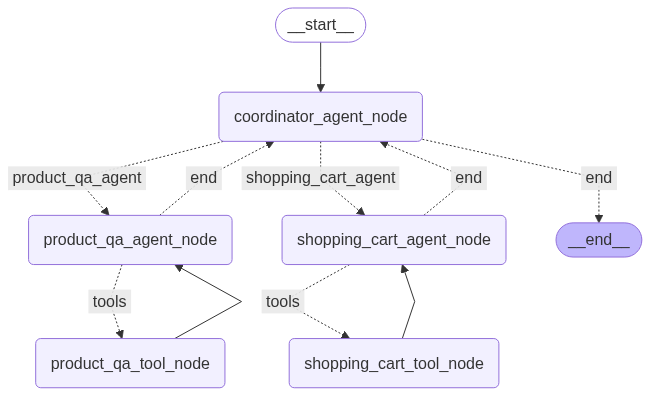

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Example Graph Invocations

In [22]:
initial_state = {
    "messages": [{"role": "user", "content": "What is the weather today?"}],
    "user_id": "adlkfjdslkfgjs",
    "cart_id": "afnvjenevjnjvev",
    "product_qa_available_tools": product_qa_tool_descriptions,
    "shopping_cart_available_tools": shopping_cart_tool_descriptions
}
result = await graph.ainvoke(initial_state)

In [23]:
result

{'messages': [{'role': 'user', 'content': 'What is the weather today?'},
  AIMessage(content="I'm sorry, but I can only assist with shopping-related queries such as finding products, answering questions about items, or helping with your shopping cart. If you have any questions about shopping, please let me know!", additional_kwargs={}, response_metadata={})],
 'answer': "I'm sorry, but I can only assist with shopping-related queries such as finding products, answering questions about items, or helping with your shopping cart. If you have any questions about shopping, please let me know!",
 'coordinator_iteration': 1,
 'coordinator_final_answer': True,
 'product_qa_available_tools': [{'name': 'get_formatted_item_context',
   'description': 'Get the top k context, each representing an inventory item for a given query.',
   'parameters': {'type': 'object',
    'properties': {'query': {'title': 'Query',
      'type': 'string',
      'description': 'The query to get the top k context for'},

In [24]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "user_id": "adlkfjdslkfgjs",
    "cart_id": "afnvjenevjnjvev",
    "product_qa_available_tools": product_qa_tool_descriptions,
    "shopping_cart_available_tools": shopping_cart_tool_descriptions
}
result = await graph.ainvoke(initial_state)

In [ ]:
result

In [25]:
initial_state = {
    "messages": [{"role": "user", "content": "Can you add an item with ID B09NLTDHQ6 to my cart?"}],
    "user_id": "adlkfjdslkfgjs",
    "cart_id": "afnvjenevjnjvev",
    "product_qa_available_tools": product_qa_tool_descriptions,
    "shopping_cart_available_tools": shopping_cart_tool_descriptions
}
result = await graph.ainvoke(initial_state)

In [ ]:
result

In [26]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself, a laptop bag for my wife and something cool for my kids? Can you also pick the items with the best user reviews and add them to my shopping cart?"}],
    "user_id": "adlkfjdslkfgjs",
    "cart_id": "afnvjenevjnjvev",
    "product_qa_available_tools": product_qa_tool_descriptions,
    "shopping_cart_available_tools": shopping_cart_tool_descriptions
}
result = await graph.ainvoke(initial_state)